In [1]:
 import sys
! whoami
 print(sys.executable)
 print(sys.version)
 print(sys.version_info)
# tested on aws lightsail instance 21 July 2020 using python38 kernel spec

compthink
/opt/conda/envs/python/bin/python
3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=3, releaselevel='final', serial=0)


# Hypothesis Testing
In this notebook we introduce tests for two independent groups - a common situation in both experimental and observational research.  

In experimental research, the sample sizes may be quite small. However the methods will work fine for large data (many records) sets.
An important concept is that the two groups are known to be different by some classification or descriptive variable, and can be separated based on that variable.  
Furthermore the ideas of:

   1) before vs. after (some treatment); 

   2) pristine vs. impacted; 

   3) fractured vs. unfractured; 

   4) upgradient vs. downgradient;

   5) other such exclusive distinctions;

are utterly important in these kinds of comparisons. 

Also the concept of `pairing` 

Consider the example of BMP (a stormwater treatment device) performance monitoring. 
If we monitor a BMP upstream and downstream during different storms, and a sample is collected at <strong>both</strong> locations during the different events, these are `PAIRED` samples, and are the subject of another notebook.

If on the other hand we collect grab samples from a stream at some location on many different days, and in the field notes we observe that some days, the bayou smelled bad (a classification variable), and other days there was no smell, then these two sets of samples (smelly and yummy) are `unpaired`.  

Before-after sampling is also usually `unpaired`. 

### An example -- Assume UNPAIRED
Consider two sets of observations of organic nitrogen in samples from an industrial region and from a residential region.
First build the data model, and make a boxplot to get an idea of what to expect, our question is are the two areas different? Or more philosophically, given an observation can we make a good guess of whether it is a residential or industrial sample?

<AxesSubplot:>

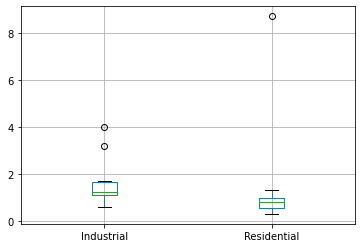

In [2]:
industrial_organic_nitrogen=[0.59,0.87,1.1,1.1,1.2,1.3,1.6,1.7,3.2,4.0] # industrial data as a list
residential_organic_nitrogen=[0.3,0.36,0.5,0.7,0.7,0.9,0.92,1.0,1.3,8.7] # residential data as a list
import pandas as pd
import numpy as np
# join the two lists
organicNH3 = [industrial_organic_nitrogen,residential_organic_nitrogen]
#transpose them
organicNH3 = np.array(organicNH3).T
#build dataframe
df = pd.DataFrame(organicNH3, columns=['Industrial', 'Residential'])
df.plot.box(grid='True')

Examine the boxplots, the residential has a slightly smaller mean value, and except for a single large value all values are smaller than the industrial sample.
Lets look closer at the dataframe statistics

In [3]:
df.describe()

,Industrial,Residential
count,10.000000,10.000000
mean,1.666000,1.538000
std,1.084714,2.534902
min,0.590000,0.300000
25%,1.100000,0.550000
50%,1.250000,0.800000
75%,1.675000,0.980000
max,4.000000,8.700000


Here we see that the IQR (inter-quartile range) for the residential is entirely contained within the 1st quartile of the industrial sample - an indicator that the two underlying distributions are different. But from the boxplot the two samples are still kind of close. Now lets consider hypothesis tests.

## Non-Parametric Tests

A non-parametric test means we make no judgement or claim of underlying distribution type.  
Such tests do not depand on the data following some particular probability rules, but have low power to discriminate (tell if things are different) unless the data are substantially different. 

A common non-parametric test is a Rank-Sum test (https://www.itl.nist.gov/div898/software/dataplot/refman1/auxillar/ranksum.htm) in most statistical packages it is some version of the Mann-Whitney(https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) or Wilcoxon test https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test). Mann-Whitney is appropriate for unpaired samples; Wilcoxon for paired -- there are more tests, these are simply a start.

### Mann-Whitney U test.
The default assumption or null hypothesis is that there is no difference between the distributions of the data samples. Rejection of this hypothesis suggests that there is likely some difference between the samples. More specifically, the test determines whether it is equally likely that any randomly selected observation from one sample will be greater or less than a sample in the other distribution. If violated, it suggests differing distributions.

In [4]:
from scipy.stats import mannwhitneyu # import a useful non-parametric test
stat, p = mannwhitneyu(industrial_organic_nitrogen,residential_organic_nitrogen)
print('statistic=%.3f, p-value at rejection =%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

statistic=23.500, p-value at rejection =0.025
Probably different distributions


The reported p-value is the level of significance at rejection
The interpretation in this example is that the null hypothesis (distributions are the same) is to be rejected at a
significance level of $\alpha$ = 0.05. If the p-value were larger than the significance level,
we would not have sufficient evidence to reject the null hypothesis.

A useful way to check your interpretation is to perform the test on the same data, the result should do not reject

In [5]:
stat, p = mannwhitneyu(industrial_organic_nitrogen,industrial_organic_nitrogen)
print('statistic=%.3f, p-value at rejection =%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

statistic=50.000, p-value at rejection =0.485
Probably the same distribution


A useful rule-of-thumb way to interpret p-value, is that it represents a probability that the distributions are the same.
So in the second case just above the probability that the distribution of industrial organic nitrogen is self-similar is $2*(0.485)=0.97$, the orginal case is that the probability that the distribution of industrial organic nitrogen is the same as residential organic nitrogen is $2*(0.025)=0.05$, quite a bit smaller.  This is a gross simplification, but often helpful in remembering the meaning of p-value.

## Parametric Tests
A parametric test means we make a judgement or requirement of underlying distribution type, often `normal`
Such tests depend on the data following some particular probability rules, but better power to discriminate (tell if things are different) even when the data appear similar. 

### T-Test

The t-test is a well documented procedure for comparing two sets of data. It assumes
`normality` of the data, and this assumption is critical to defendable application of the
test. One can compute t-statistics and make decisions from t-tables, but departure
from normality means that the level of significance may be much different than
expected.
Some considerations about t-tests (as well as the rank-sum test).
1. t-test compares means between two sets of data.
2. t-test assumes normality of both sets of data.
3. Both tests compare central tendency of the data. Rank-sum is probably adaptable to other location measures (i.e. P25). 

I am unaware if this is commonly done or not.
The URL (https://machinelearningmastery.com/how-to-code-the-students-t-test-from-scratch-in-python/) presents the t-test statistic and a python primative implementation (it does use numpy), like before we compute a statistic from the data, compare it to a critical value, and make a decision.
A script using an already built module is shown below, and implements much of the same decision logic as the non-parametric test.

In [6]:
from scipy import stats
results = stats.ttest_ind(industrial_organic_nitrogen, residential_organic_nitrogen )
print('statistic=%.3f, p-value at rejection =%.3f ' % (results[0], results[1]))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

statistic=0.147, p-value at rejection =0.885 
Probably the same distribution


## An example -- Assume PAIRED 
In some cases, the data samples may be paired.

There are many reasons why this may be the case, for example, the samples are related or matched in some way or represent two measurements of the same technique. More specifically, each sample is independent, but comes from the same population.

Examples of paired samples in data science/machine learning might be the same algorithm evaluated on different datasets or different algorithms evaluated on exactly the same training and test data.  Usually experiments designed to test a treatment produce paired samples, the control and the treatment.

The samples are no longer independent, therefore the Mann-Whitney U test cannot be used, and the T-test assuming independent is also no longer appropriate.

### Wilcoxon Signed-Rank Test

For a non-parametric test, the Wilcoxon signed-rank test is used, also called the Wilcoxon T test, named for Frank Wilcoxon. It is the equivalent of the paired Student T-test, but for ranked data instead of real valued data with a Gaussian distribution.

The default assumption for the test, the null hypothesis, is that the two samples have the same distribution.  We can build the test in the same fashion.  In this example the pairing matters and a different outcome is inferred

In [7]:
from scipy.stats import wilcoxon # import a useful non-parametric test
stat, p = wilcoxon(industrial_organic_nitrogen,residential_organic_nitrogen)
print('statistic=%.3f, p-value at rejection =%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

statistic=10.000, p-value at rejection =0.084
Probably the same distribution


### T-Test Paired 
Dependent t-test for paired_samples is described at (https://en.wikipedia.org/wiki/Student%27s_t-test). A similarily useful test is the Welch's T-test, which is left as an exercise. The paired T-test below is nearly the same function syntax as before

In [8]:
results = stats.ttest_rel(industrial_organic_nitrogen, residential_organic_nitrogen)
print('statistic=%.3f, p-value at rejection =%.3f ' % (results[0], results[1]))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

statistic=0.230, p-value at rejection =0.823 
Probably the same distribution
